## Delay Interbed Drainage

This problem simulates the drainage of a thick interbed caused by a step
decrease in hydraulic head in the aquifer and is based on MODFLOW-2000 subsidence
package sample problem 1.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl

import flopy
import git
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwf-csub-p02"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()
tbls_path = root / "tables" if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

# ### Define parameters
#
# Define model units, parameters and other settings.

In [2]:
# Scenario-specific parameters
parameters = {
    "ex-gwf-csub-p02a": {
        "head_based": True,
        "bed_thickness": (1.0,),
        "kv": (2.5e-06,),
        "ndelaycells": 19,
    },
    "ex-gwf-csub-p02b": {
        "head_based": False,
        "bed_thickness": (1.0,),
        "kv": (2.5e-06,),
        "ndelaycells": 19,
    },
    "ex-gwf-csub-p02c": {
        "head_based": True,
        "bed_thickness": (1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0),
        "kv": (2.5e-06, 1e-05, 6.25e-05, 0.00025, 0.001, 0.00625, 0.025),
        "ndelaycells": 1001,
    },
}

# Model units
length_units = "meters"
time_units = "days"

# Model parameters
nper = 1  # Number of periods
nlay = 1  # Number of layers
ncol = 3  # Number of columns
nrow = 1  # Number of rows
delr = 1.0  # Column width ($m$)
delc = 1.0  # Row width ($m$)
top = 0.0  # Top of the model ($ft$)
botm = -1000.0  # Layer bottom elevations ($m$)
strt = 0.0  # Starting head ($m$)
icelltype = 0  # Cell conversion type
k11 = 1.0e6  # Horizontal hydraulic conductivity ($m/d$)
sgm = 1.7  # Specific gravity of moist soils (unitless)
sgs = 2.0  # Specific gravity of saturated soils (unitless)
tau0 = 1000.0  # Interbed drainage time constant (unitless)
cg_theta = 0.2  # Coarse-grained material porosity (unitless)
ske = 1.0e-5  # Elastic specific storage ($1/m$)
skv = 1.0e-2  # Inelastic specific storage ($1/m$)
theta = 0.45  # Interbed porosity (unitless)
h0 = 1.0  # Initial interbed head ($m$)
head_offset = 1.0  # Initial preconsolidation head ($m$)

# Time discretization
tdis_ds = ((1000.0, 100, 1.05),)

# Constant head cells
c6 = []
for j in range(0, ncol, 2):
    c6.append([0, 0, j, strt])

# Solver parameters
nouter = 1000
ninner = 300
hclose = 1e-9
rclose = 1e-6
linaccel = "bicgstab"
relax = 0.97

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models(
    name,
    subdir_name=".",
    head_based=True,
    bed_thickness=1.0,
    kv=2e-6,
    ndelaycells=19,
):
    sim_ws = os.path.join(workspace, name)
    if subdir_name is not None:
        sim_ws = os.path.join(sim_ws, subdir_name)
    sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        outer_maximum=nouter,
        outer_dvclose=hclose,
        linear_acceleration=linaccel,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        relaxation_factor=relax,
        rcloserecord=f"{rclose} strict",
    )
    gwf = flopy.mf6.ModflowGwf(
        sim, modelname=name, save_flows=True, newtonoptions="newton"
    )
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    # gwf obs
    flopy.mf6.ModflowUtlobs(
        gwf,
        digits=10,
        print_input=True,
        continuous={"gwf_obs.csv": [("h1_1_2", "HEAD", (0, 0, 1))]},
    )

    flopy.mf6.ModflowGwfic(gwf, strt=strt)
    flopy.mf6.ModflowGwfnpf(
        gwf,
        icelltype=icelltype,
        k=k11,
        save_specific_discharge=True,
    )
    flopy.mf6.ModflowGwfsto(gwf, iconvert=icelltype, ss=0.0, sy=0, transient={0: True})
    if head_based:
        hb_bool = True
        pc0 = head_offset
        tsgm = None
        tsgs = None
    else:
        hb_bool = None
        pc0 = -head_offset
        tsgm = sgm
        tsgs = sgs
    sub6 = [
        [0, 0, 0, 1, "delay", pc0, bed_thickness, 1.0, skv, ske, theta, kv, h0, "ib1"]
    ]
    csub = flopy.mf6.ModflowGwfcsub(
        gwf,
        print_input=True,
        save_flows=True,
        head_based=hb_bool,
        ndelaycells=ndelaycells,
        boundnames=True,
        ninterbeds=1,
        sgm=tsgm,
        sgs=tsgs,
        cg_theta=cg_theta,
        cg_ske_cr=0.0,
        beta=0.0,
        packagedata=sub6,
    )
    opth = f"{name}.csub.obs"
    csub_csv = opth + ".csv"
    obs = [
        ("tcomp", "interbed-compaction", (0,)),
        ("sk", "sk", (0,)),
        ("qtop", "delay-flowtop", (0,)),
        ("qbot", "delay-flowbot", (0,)),
    ]
    for k in range(ndelaycells):
        tag = f"H{k + 1:04d}"
        obs.append((tag, "delay-head", (0,), (k,)))
    if not head_based:
        iposm = int(ndelaycells / 2) + 1
        iposb = ndelaycells - 1
        obs += [
            ("est", "delay-estress", (0,), (0,)),
            ("esm", "delay-estress", (0,), (iposm,)),
            ("esb", "delay-estress", (0,), (iposb,)),
            ("gs", "gstress-cell", (0, 0, 1)),
            ("es", "estress-cell", (0, 0, 1)),
        ]
    orecarray = {csub_csv: obs}
    csub.obs.initialize(
        filename=opth, digits=10, print_input=True, continuous=orecarray
    )

    flopy.mf6.ModflowGwfchd(gwf, stress_period_data={0: c6})

    flopy.mf6.ModflowGwfoc(gwf, printrecord=[("BUDGET", "ALL")])
    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent)
    assert success, buff

### Plotting results

Define functions to plot model results, beginning with an analytical solution to superimpose over the simulated solution.

In [4]:
def analytical_solution(z, t, dh=1.0, b0=1.0, ssk=100.0, vk=0.025, n=100, silent=True):
    v = 0.0
    e = np.exp(1)
    pi = np.pi
    pi2 = np.pi**2
    # calculate infinite sum
    for k in range(n):
        fk = float(k)
        tauk = (0.5 * b0) ** 2.0 * ssk / ((2.0 * fk + 1.0) ** 2.0 * vk)
        ep = ((2.0 * fk + 1.0) ** 2 * pi2 * vk * t) / (4.0 * ssk * (0.5 * b0) ** 2.0)
        rad = (2.0 * fk + 1.0) * pi * z / b0
        v += ((-1.0) ** fk / (2.0 * fk + 1.0)) * (e**-ep) * np.cos(rad)
        if not silent:
            print(f"{k:5d} {tauk:20g} {rad:20g} {v:20g}")
    return dh - 4.0 * dh * v / pi


# Set figure properties specific to the problem
figure_size = (6.8, 3.4)
arrow_props = dict(facecolor="black", arrowstyle="-", lw=0.5)


def plot_grid(sim, silent=True):
    with styles.USGSMap() as fs:
        name = sim.name
        gwf = sim.get_model(name)

        fig, ax = plt.subplots(figsize=(6.8, 2.0))
        mc = flopy.plot.PlotCrossSection(model=gwf, line={"Row": 0}, ax=ax)

        ax.fill_between([0, 1], y1=0, y2=botm, color="cyan", alpha=0.5)
        styles.add_text(
            ax=ax,
            text="Constant head",
            x=0.5,
            y=-500.0,
            bold=False,
            italic=False,
            transform=False,
            va="center",
            ha="center",
            fontsize=9,
        )
        ax.fill_between([2, 3], y1=0, y2=botm, color="cyan", alpha=0.5)
        styles.add_text(
            ax=ax,
            text="Constant head",
            x=2.5,
            y=-500.0,
            bold=False,
            italic=False,
            transform=False,
            va="center",
            ha="center",
            fontsize=9,
        )
        ax.fill_between([1, 2], y1=-499.5, y2=-500.5, color="brown", alpha=0.5)
        styles.add_annotation(
            ax=ax,
            text="Delay interbed",
            xy=(1.5, -510.0),
            xytext=(1.6, -300),
            bold=False,
            italic=False,
            fontsize=9,
            ha="center",
            va="center",
            zorder=100,
            arrowprops=arrow_props,
        )
        mc.plot_grid(color="0.5", lw=0.5, zorder=100)

        ax.set_xlim(0, 3)
        ax.set_ylabel("Elevation, in meters")
        ax.set_xlabel("x-coordinate, in meters")
        styles.remove_edge_ticks(ax)

        plt.tight_layout()

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-grid.png"
            if not silent:
                print(f"saving...'{fpth}'")
            fig.savefig(fpth)


def plot_head_based(sim, silent=True):
    with styles.USGSPlot() as fs:
        name = sim.name

        # get csub observations
        ws = sim.simulation_data.mfpath.get_sim_path()
        s = flopy.mf6.MFSimulation().load(sim_ws=ws, verbosity_level=0)
        gwf = s.get_model(name)
        cobs = gwf.csub.output.obs().data

        # calculate the compaction analytically
        ac = []
        nz = 100
        thick = parameters[name]["bed_thickness"][0]
        kv = parameters[name]["kv"][0]
        dhalf = thick * 0.5
        az = np.linspace(-dhalf, dhalf, num=nz)
        dz = az[1] - az[0]
        for tt in cobs["totim"]:
            c = 0.0
            for jdx, zz in enumerate(az):
                f = 1.0
                if jdx == 0 or jdx == nz - 1:
                    f = 0.5
                h = analytical_solution(zz, tt, ssk=skv, vk=kv, n=200, dh=1.0)
                c += h * skv * f * dz
            ac.append(c)
        ac = np.array(ac)

        # calculate normalized simulation time
        tpct = cobs["totim"] * 100 / tau0

        # plot the results
        fig = plt.figure(figsize=figure_size)
        gs = mpl.gridspec.GridSpec(1, 2, figure=fig)

        idx = 0
        ax = fig.add_subplot(gs[idx])
        ax.plot(
            tpct,
            100 * ac / skv,
            marker=".",
            lw=0,
            ms=3,
            color="red",
            label="Analytical",
        )
        ax.plot(
            tpct,
            100 * cobs["TCOMP"] / skv,
            label="Simulated",
            color="black",
            lw=1,
            zorder=100,
        )
        leg = styles.graph_legend(ax, loc="lower right")
        ax.set_xticks(np.arange(0, 110, 10))
        ax.set_yticks(np.arange(0, 110, 10))
        ax.set_xlabel("Percent of time constant")
        ax.set_ylabel("Compaction, in percent of ultimate value")
        ax.set_xlim(0, 100)
        ax.set_ylim(0, 100)
        styles.heading(ax, letter="A")
        styles.remove_edge_ticks(ax)

        idx += 1
        ax = fig.add_subplot(gs[idx])
        ax.plot(tpct, 100 * (ac - cobs["TCOMP"]) / skv, lw=1, ls=":", color="black")
        ax.set_xticks(np.arange(0, 110, 10))
        ax.set_yticks(np.arange(0, 2.2, 0.2))
        ax.set_xlabel("Percent of time constant")
        ax.set_ylabel(
            "Analytical minus simulated subsidence,\nin percent of ultimate value"
        )
        ax.set_xlim(0, 100)
        ax.set_ylim(0, 2)
        styles.heading(ax, letter="B")
        styles.remove_edge_ticks(ax)

        plt.tight_layout()

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{name}-01.png"
            if not silent:
                print(f"saving...'{fpth}'")
            fig.savefig(fpth)


def plot_effstress(sim, silent=True):
    verbose = not silent
    with styles.USGSPlot() as fs:
        name = sim.name

        # get effective stress csub observations
        gwf = sim.get_model(name)
        cobs = gwf.csub.output.obs().data

        # get head-based csub observations
        name0 = name.replace("-p02b", "-p02a")
        ws0 = os.path.join(workspace, name0)
        sim0 = flopy.mf6.MFSimulation().load(sim_ws=ws0, verbosity_level=0)
        gwf0 = sim0.get_model(name0)
        cobs0 = gwf0.csub.output.obs().data

        # calculate normalized simulation time
        tpct = cobs["totim"] * 100 / tau0

        # plot the results
        fig = plt.figure(figsize=figure_size)
        gs = mpl.gridspec.GridSpec(1, 2, figure=fig)

        idx = 0
        ax = fig.add_subplot(gs[idx])
        ax.plot(
            tpct,
            100 * cobs0["TCOMP"] / skv,
            lw=0,
            marker=".",
            ms=3,
            color="#238A8DFF",
            label="Head-based",
        )
        ax.plot(
            tpct,
            100 * cobs["TCOMP"] / skv,
            lw=0.75,
            label="Effective stress-based",
            color="black",
            zorder=100,
        )
        leg = styles.graph_legend(ax, loc="lower right")
        ax.set_xticks(np.arange(0, 110, 10))
        ax.set_yticks(np.arange(0, 110, 10))
        ax.set_xlabel("Percent of time constant")
        ax.set_ylabel("Compaction, in percent of ultimate value")
        ax.set_xlim(0, 100)
        ax.set_ylim(0, 100)
        styles.heading(ax, letter="A")
        styles.remove_edge_ticks(ax)

        idx += 1
        ax = fig.add_subplot(gs[idx])
        ax.plot(
            tpct,
            100 * (cobs0["TCOMP"] - cobs["TCOMP"]) / skv,
            lw=1,
            ls=":",
            color="black",
        )
        ax.set_xticks(np.arange(0, 110, 10))
        ax.set_xlabel("Percent of time constant")
        ax.set_ylabel(
            "Head-based minus effective stress-based\nsubsidence, in percent of ultimate value"
        )
        ax.set_xlim(0, 100)
        styles.heading(ax, letter="B")
        styles.remove_edge_ticks(ax)

        plt.tight_layout()

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{name}-01.png"
            if not silent:
                print(f"saving...'{fpth}'")
            fig.savefig(fpth)


def get_subdirs(sim):
    """Get subdirectory names"""
    name = sim.name
    # get the subdirectory names
    pth = os.path.join(workspace, name)
    hb_dirs = [
        name
        for name in sorted(os.listdir(pth))
        if os.path.isdir(os.path.join(pth, name)) and name.startswith("hb-")
    ]
    es_dirs = [
        name
        for name in sorted(os.listdir(pth))
        if os.path.isdir(os.path.join(pth, name)) and name.startswith("es-")
    ]
    return hb_dirs, es_dirs


def fill_heads(rec_arr, ndcells):
    """Process interbed heads"""
    arr = np.zeros((rec_arr.shape[0], ndcells), dtype=float)
    for i in range(100):
        for j in range(ndcells):
            name = f"H{j + 1:04d}"
            arr[i, j] = rec_arr[name][i]
    return arr


def plot_comp_q_comparison(sim, silent=True):
    """Plot the results for multiple interbed thicknesses"""
    with styles.USGSPlot():
        name = sim.name
        thicknesses = parameters[name]["bed_thickness"]

        # get the subdirectory names
        hb_dirs, es_dirs = get_subdirs(sim)

        # setup the figure
        fig = plt.figure(figsize=figure_size)
        gs = mpl.gridspec.GridSpec(1, 2, figure=fig)

        # set color
        cmap = plt.get_cmap("viridis")
        cNorm = mpl.colors.Normalize(vmin=0, vmax=6)
        scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)

        axes = []
        for idx in range(2):
            ax = fig.add_subplot(gs[idx])
            if idx == 0:
                ax.set_yticks(np.arange(-0.40, 0.1, 0.05))
                ax.set_ylim(-0.40, 0)
                ax.set_xlim(0, 100)
                ylabel = (
                    "Head-based minus effective stress-based\nsubsidence, "
                    "in % of ultimate value"
                )
            else:
                ax.set_ylim(0, 8)
                ax.set_xlim(0, 100)
                ylabel = (
                    "Top minus bottom interbed effective stress-\nbased "
                    "rate, in % of head-based drainage rate"
                )
            ax.set_xlabel("Percent of time constant")
            ax.set_ylabel(ylabel)
            styles.heading(ax, letter=chr(ord("A") + idx))
            axes.append(ax)
        plt.subplots_adjust(wspace=0.36)

        for idx, (hb_dir, es_dir) in enumerate(zip(hb_dirs, es_dirs)):
            sim_ws = os.path.join(workspace, name, hb_dir)
            s = flopy.mf6.MFSimulation().load(sim_ws=sim_ws, verbosity_level=0)
            g = s.get_model(name)
            hb_obs = g.csub.output.obs().data

            ws0 = os.path.join(workspace, name, es_dir)
            s0 = flopy.mf6.MFSimulation().load(sim_ws=ws0, verbosity_level=0)
            g0 = s0.get_model(name)
            es_obs = g0.csub.output.obs().data

            # calculate normalized simulation time
            tpct = hb_obs["totim"] * 100 / tau0

            thickness = thicknesses[idx]
            if idx == 0:
                color = "black"
            else:
                color = scalarMap.to_rgba(idx - 1)
            label = f"Thickness = {int(thickness):>3d} m"

            v = 100.0 * (hb_obs["TCOMP"] - es_obs["TCOMP"]) / (skv * thickness)
            ax = axes[0]
            ax.plot(tpct, v, color=color, lw=0.75, label=label)

            denom = hb_obs["QTOP"] + hb_obs["QBOT"]
            v = 100 * (es_obs["QTOP"] - es_obs["QBOT"]) / denom
            ax = axes[1]
            ax.plot(tpct, v, color=color, lw=0.75, label=label)

        # legend
        ax = axes[-1]
        leg = styles.graph_legend(ax, loc="upper right")

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{name}-01.png"
            if not silent:
                print(f"saving...'{fpth}'")
            fig.savefig(fpth)


def plot_head_comparison(sim, silent=True):
    """Plot the interbed head results for multiple interbed thicknesses"""
    with styles.USGSPlot():
        name = sim.name
        ndcells = parameters[name]["ndelaycells"]
        thicknesses = parameters[name]["bed_thickness"]

        # get the subdirectory names
        hb_dirs, es_dirs = get_subdirs(sim)

        # setup the figure
        fig = plt.figure(figsize=figure_size)
        fig.subplots_adjust(left=0.06, right=0.95, top=0.95, bottom=0.15, wspace=0.1)
        gs = mpl.gridspec.GridSpec(1, 6, figure=fig)
        z = np.linspace(0, 1, ndcells)
        yticks = np.arange(0, 1.1, 0.1)

        # set color
        cmap = plt.get_cmap("viridis")
        cNorm = mpl.colors.Normalize(vmin=0, vmax=6)
        scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)

        # percentages to evaluate
        pct_vals = (1, 5, 10, 50, 100)

        axes = []
        for idx in range(6):
            ax = fig.add_subplot(gs[idx])
            ax.set_ylim(1, 0)
            ax.set_xlim(-5, 5)
            if idx < 5:
                styles.heading(ax, letter=chr(ord("A") + idx))
                ax.set_yticks(yticks)
                styles.remove_edge_ticks(ax)
                text = r"$\frac{t}{\tau_0}$ = " + f"{pct_vals[idx] / 100.0}"
                ax.text(
                    0.25,
                    0.01,
                    text,
                    ha="center",
                    va="bottom",
                    transform=ax.transAxes,
                    fontsize=8,
                )
            else:
                ax.set_xticks([])
                ax.set_yticks([])

            if idx == 0:
                ax.set_ylabel("Interbed position, relative to interbed thickness")
            else:
                if idx == 2:
                    text = (
                        "Difference in head-based and effective stress-based\n"
                        "interbed heads, in percent of head-based interbed heads"
                    )
                    ax.set_xlabel(text)
                ax.set_yticklabels([])
            axes.append(ax)

        for idx, (hb_dir, es_dir) in enumerate(zip(hb_dirs, es_dirs)):
            sim_ws = os.path.join(workspace, name, hb_dir)
            s = flopy.mf6.MFSimulation().load(sim_ws=sim_ws, verbosity_level=0)
            g = s.get_model(name)
            hb_obs = g.csub.output.obs().data
            hb_arr = fill_heads(hb_obs, ndcells)

            ws0 = os.path.join(workspace, name, es_dir)
            s0 = flopy.mf6.MFSimulation().load(sim_ws=ws0, verbosity_level=0)
            g0 = s0.get_model(name)
            es_obs = g0.csub.output.obs().data
            es_arr = fill_heads(es_obs, ndcells)
            #
            # pth = os.path.join(ws, name, hb_dir, "{}.csub.obs.csv".format(name))
            # hb_obs = np.genfromtxt(pth, names=True, delimiter=",")
            # hb_arr = fill_heads(hb_obs, ndcells)
            #
            # pth = os.path.join(ws, name, es_dir, "{}.csub.obs.csv".format(name))
            # es_obs = np.genfromtxt(pth, names=True, delimiter=",")
            # es_arr = fill_heads(es_obs, ndcells)

            # calculate normalized simulation time
            tpct = hb_obs["totim"] * 100 / tau0

            # calculate location closest to 1, 5, 10, 50, and 100 percent of time constant
            locs = {}
            for i in pct_vals:
                for jdx, t in enumerate(tpct):
                    if t <= i:
                        locs[i] = jdx

            for jdx, (key, ivalue) in enumerate(locs.items()):
                # add data to the subplot
                ax = axes[jdx]
                if idx == 0:
                    color = "black"
                else:
                    color = scalarMap.to_rgba(idx - 1)
                hhb = hb_arr[ivalue, :]
                hes = es_arr[ivalue, :]
                v = 100.0 * (hhb - hes) / hhb
                ax.plot(v, z, lw=0.75, color=color)

        # legend
        ax = axes[-1]
        ax.set_ylim(1, 0)
        ax.set_xlim(-5, 5)
        ax.spines["top"].set_color("none")
        ax.spines["bottom"].set_color("none")
        ax.spines["left"].set_color("none")
        ax.spines["right"].set_color("none")
        ax.patch.set_alpha(0.0)
        for ic, b in enumerate(thicknesses):
            if ic == 0:
                color = "black"
            else:
                color = scalarMap.to_rgba(ic - 1)
            label = f"Thickness = {int(b):>3d} m"
            ax.plot([-1, -1], [-1, -1], lw=0.75, color=color, label=label)

        leg = styles.graph_legend(ax, loc="center", bbox_to_anchor=(0.64, 0.5))

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{name}-02.png"
            if not silent:
                print(f"saving...'{fpth}'")
            fig.savefig(fpth)


def plot_results(sim, silent=True):
    name = sim.name
    if name.endswith("a"):
        plot_grid(sim, silent=silent)
        plot_head_based(sim, silent=silent)
    elif name.endswith("b"):
        plot_effstress(sim, silent=silent)
    elif name.endswith("c"):
        plot_comp_q_comparison(sim, silent=silent)
        plot_head_comparison(sim, silent=silent)

### Running the example

Define a function to run the example scenarios, then plot results.

In [5]:
def scenarios(idx, silent=True):
    key = list(parameters.keys())[idx]
    interbed_thickness = parameters[key]["bed_thickness"]
    interbed_kv = parameters[key]["kv"]
    params = parameters[key].copy()
    if len(interbed_thickness) == 1:
        params["bed_thickness"] = interbed_thickness[0]
        params["kv"] = interbed_kv[0]

        sim = build_models(key, **params)
        if write:
            write_models(sim, silent=silent)
        if run:
            run_models(sim, silent=silent)
    else:
        for b, kv in zip(interbed_thickness, interbed_kv):
            for head_based in (True, False):
                if head_based:
                    subdir_name = "hb-"
                else:
                    subdir_name = "es-"
                subdir_name += f"{int(b):03d}"
                params["head_based"] = head_based
                params["bed_thickness"] = b
                params["kv"] = kv

                sim = build_models(key, subdir_name=subdir_name, **params)
                if write:
                    write_models(sim, silent=silent)
                if run:
                    run_models(sim, silent=silent)
    if plot:
        plot_results(sim, silent=silent)

Run and plot the head based solution.

run_models took 43.29 ms


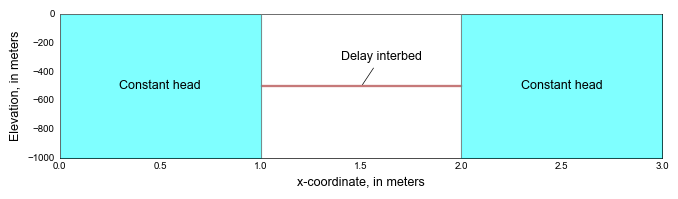

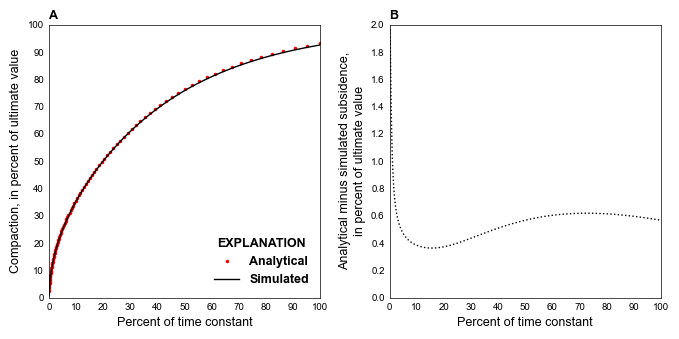

In [6]:
scenarios(0)

Run and plot the effective stress solution.

run_models took 44.40 ms


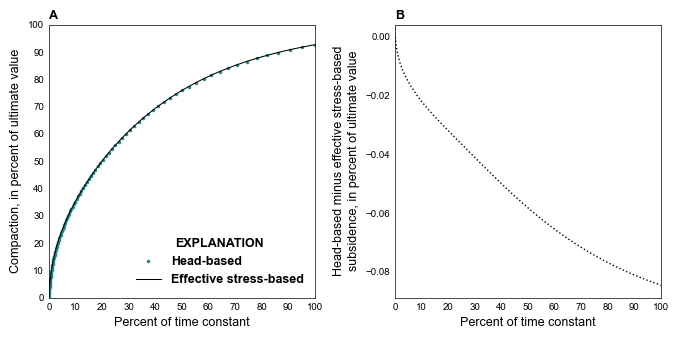

In [7]:
scenarios(1)

Run and plot the head based for multiple interbed thicknesses.

run_models took 401.25 ms


run_models took 433.37 ms


run_models took 406.91 ms


run_models took 430.53 ms


run_models took 398.28 ms


run_models took 433.45 ms


run_models took 402.91 ms


run_models took 426.42 ms


run_models took 423.94 ms


run_models took 450.70 ms


run_models took 402.92 ms


run_models took 442.47 ms


run_models took 439.83 ms


run_models took 433.83 ms


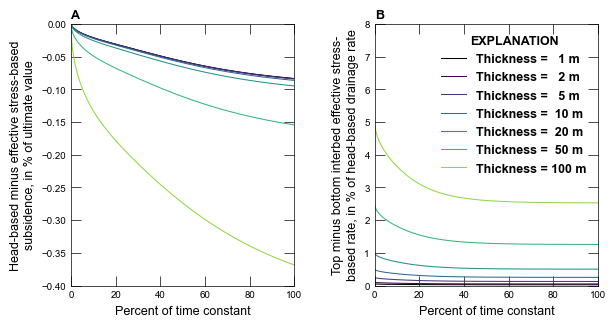

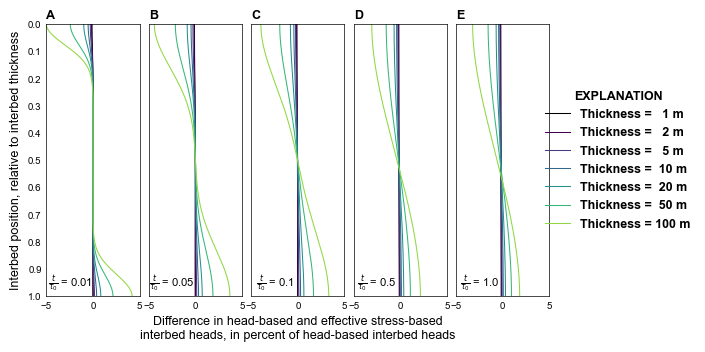

In [8]:
scenarios(2)